In [13]:
%pylab inline

import matplotlib as pyplot
import os
import pandas as pd

ANNOTDIR = "/storage/mgymrek/gtex/annotations/"
FEATUREDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
mergefile = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Best_causality.Table'
SCORETYPE = ""
MINDIST = 1500
MINQ = 1
percentiles = [0,30] + list(np.arange(40, 101, 10))


# Annotate TSS/UTRs
def GetDistTss(x):
    if x["strand"] == "+":
        return x["best.str.start"] - x["start"]
    elif x["strand"] == "-":
        return -1*(x["best.str.start"] - x["stop"])
    else:
        return float("nan")


def GetBootstrapCI(data, func):
    numiter = 1000
    vals = []
    for i in range(numiter):
        x = np.random.choice(data, size=data.shape[0], replace=True)
        vals.append(func(x))
    se = np.sqrt(np.var(vals))
    return np.mean(vals)-1.96*se, np.mean(vals)+1.96*se


Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pyplot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
# Plot TSS/TES
data1 = pd.read_csv(os.path.join(FEATUREDIR, "Merged_Causality_TSS_TSS.tab"), sep="\t")
data1 = data1[data1["best.score"] >= 0]
GG = pd.read_csv('/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv', sep='\t')
EE =GG.loc[GG['E.tissues']>=1]

data = data1.loc[data1['gene'].isin(list(EE['gene']))]

bins = np.percentile(data[data["best.q"]<=MINQ]["best.score"], q = percentiles)
binlabels = []
tss = []
tss_low = []
tss_high = []
tes = []
tes_low = []
tes_high = []
KST = []
for i in range(len(bins)-1):
    lb = bins[i]
    ub = bins[i+1] 
    x = data[(data["best.score"]>lb) & (data["best.score"]<= ub) & (data["best.q"]<=MINQ)]
    KST.append([lb,ub,x])
    print(lb,'\t',ub, x.shape)
    feature_tss = x["dist.to.tss"].apply(lambda x: abs(x)<MINDIST)
    feature_tes = x["dist.to.tes"].apply(lambda x: abs(x)<MINDIST)
    count_tss = np.mean(feature_tss)
    count_tes = np.mean(feature_tes)
    low_tss, high_tss = GetBootstrapCI(feature_tss, np.mean)
    low_tes, high_tes = GetBootstrapCI(feature_tes, np.mean)
    if i == 0:
        base_tss = count_tss
        base_tes = count_tes
    binlabels.append("%s-%s"%(percentiles[i], percentiles[i+1]))
    tss.append(count_tss*1.0/base_tss)
    tss_low.append(low_tss*1.0/base_tss)
    tss_high.append(high_tss*1.0/base_tss)
    tes.append(count_tes*1.0/base_tes)
    tes_low.append(low_tes*1.0/base_tes)
    tes_high.append(high_tes*1.0/base_tes)

7.281729999999998e-35 	 0.018842339999999996 (3542, 8)
0.018842339999999996 	 0.029255200000000002 (1181, 8)
0.029255200000000002 	 0.0423461 (1181, 8)
0.0423461 	 0.05880355999999999 (1181, 8)
0.05880355999999999 	 0.08620038999999997 (1181, 8)
0.08620038999999997 	 0.1268140000000001 (1181, 8)
0.1268140000000001 	 0.22474390000000002 (1181, 8)
0.22474390000000002 	 1.0 (1181, 8)


In [18]:
for i in range(0,101, 10):
    print(i,'-',i+1, data1.loc[(data1['best.score']>(i/100)) & (data1['best.score']<=((i+10)/100))].shape)

0 - 1 (8764, 8)
10 - 11 (1690, 8)
20 - 21 (549, 8)
30 - 31 (279, 8)
40 - 41 (149, 8)
50 - 51 (109, 8)
60 - 61 (77, 8)
70 - 71 (51, 8)
80 - 81 (48, 8)
90 - 91 (94, 8)
100 - 101 (0, 8)


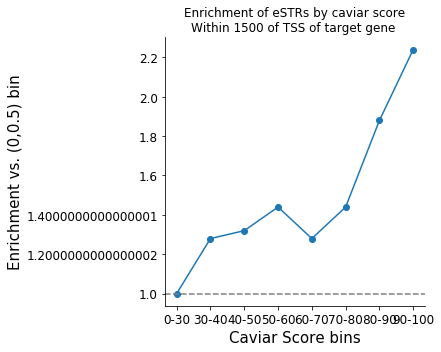

In [15]:
fig = plt.figure()
fig.set_size_inches((10, 5))

# TSS
ax = fig.add_subplot(121)
#ax.errorbar(range(len(binlabels)), tss, marker="o", yerr = [tss_low, tss_high])
ax.plot(range(len(binlabels)), tss, marker="o")
ax.set_xlabel("Caviar Score bins", size=15)
ax.set_ylabel("Enrichment vs. (0,0.5) bin", size=15)
ax.set_xticks(range(len(binlabels)))
ax.set_xticklabels(binlabels, size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y = 1.0, linestyle="dashed", color="gray")
ax.set_title("Enrichment of eSTRs by caviar score\nWithin %s of TSS of target gene "%MINDIST)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.tight_layout()


In [8]:
K = KST[-1][-1]       #pd.concat([KST[4][-1], KST[5][-1], KST[3][-1]])#top 3 bins   
GG['best.str.start'] = GG['str.start']
G = GG[["chrom","best.str.start","gene","motif","E.tissues"]]
DD = pd.merge(K, G, on=["chrom","best.str.start","gene"])
print(DD.shape)
#There are 244 in the top bin
#there are 16 of these causal genes that are eSTRs in more that 9 tissues
DD.loc[DD['E.tissues']>=9]#[['gene','best.str.start']]  105


(1181, 10)


,gene,chrom,best.str.start,best.score,best.tissue,best.q,dist.to.tss,dist.to.tes,motif,E.tissues
0,ENSG00000198131.9,chr19,5.87766e+07,0.277625,Nerve-Tibial,0.000814,36689.0,-12166.0,AAAT,9
31,ENSG00000240563.1,chr1,6.26506e+07,0.999994,Nerve-Tibial,0.000814,-9910.0,-27407.0,AT,12
34,ENSG00000176915.10,chr12,1.33348e+08,0.430601,Lung,0.001295,-9960.0,-46180.0,AGG,11
52,ENSG00000186448.10,chr3,4.46916e+07,0.274943,Skin-SunExposed,0.000942,65181.0,1598.0,AC,10
54,ENSG00000005075.11,chr7,1.02107e+08,0.361082,Artery-Tibial,0.001000,12496.0,6758.0,AAAT,11
76,ENSG00000119392.10,chr9,1.31259e+08,0.999959,Adipose-Subcutaneous,0.001013,-7985.0,-45573.0,AGAT,12
79,ENSG00000137713.11,chr11,1.11624e+08,0.244051,Lung,0.001295,13465.0,-17681.0,AAAC,10
80,ENSG00000137709.5,chr11,1.2008e+08,0.430042,Artery-Aorta,0.002351,-27394.0,-110698.0,AAAAC,12
96,ENSG00000123427.11,chr12,5.81672e+07,0.971733,Brain-Cerebellum,0.003310,1806.0,-9129.0,A,16
97,ENSG00000163864.10,chr3,1.39394e+08,0.485915,Artery-Tibial,0.001093,2881.0,-114956.0,AC,9


In [5]:
 # TES
ax = fig.add_subplot(122)
ax.errorbar(range(len(binlabels)), tes, marker="o", yerr = [tes_low, tes_high])
ax.plot(range(len(binlabels)), tes, marker="o")
ax.set_xlabel("Score bin", size=15)
ax.set_ylabel("Enrichment vs. (0,0.5) bin", size=15)
ax.set_xticks(range(len(binlabels)))
ax.set_xticklabels(binlabels, size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y = 1.0, linestyle="dashed", color="gray")
ax.set_title("Within %s of TES"%MINDIST)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#data["abs.dist.tss"] = abs(data["dist.to.tss"])
#data.sort_values("best.score", ascending=False)
plt.show()